# Dependencies

In [0]:
!pip install -q annoy

# Source data
A set of logos crawled from the internet. Dumps all to root as PNG files.

In [0]:
!wget https://data.vision.ee.ethz.ch/sagea/lld/data/LLD-logo_sample.zip
!unzip -q LLD-logo_sample.zip

--2020-02-23 14:40:33--  https://data.vision.ee.ethz.ch/sagea/lld/data/LLD-logo_sample.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27395591 (26M) [application/zip]
Saving to: ‘LLD-logo_sample.zip.1’

LLD-logo_sample.zip 100%[===================>]  26.13M  8.60MB/s    in 3.3s    

2020-02-23 14:40:37 (7.83 MB/s) - ‘LLD-logo_sample.zip.1’ saved [27395591/27395591]

replace emisuzimusic.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
import os
import skimage.io
from multiprocessing import Pool

def read_single_image(path):
  return skimage.io.imread(path, as_gray=False)

def read_all_pngs(source_path="."):
  paths = [os.path.join(source_path, filename) for filename in os.listdir(source_path) if filename.lower().endswith(".png")]
  pool = Pool()
  images = pool.map(read_single_image, paths)
  pool.close()
  pool.join()
  return images
images = read_all_pngs()
print("Loaded images: ", len(images))

Loaded images:  500


In [0]:
from skimage.transform import resize

def img_normalize(img):
  return img / 255.0

def img_resize(img, shape_resize):
  img_resized = resize(img, shape_resize, anti_aliasing=True, preserve_range=True)
  assert img_resized.shape == shape_resize
  return img_resized

class ImageTransformer(object):
  def __init__(self, shape_resize):
    self.shape_resize = shape_resize
  def __call__(self, img):
    img_transformed = img_resize(img, self.shape_resize)
    img_transformed = img_normalize(img_transformed)
    return img_transformed

def apply_transformer(imgs, shape_img_resize):
  transformer = ImageTransformer(shape_img_resize)
  pool = Pool()
  imgs_transform = pool.map(transformer, [img for img in imgs])
  pool.close()
  pool.join()
  return imgs_transform

img_shape = (100,100,3) # target shape to process with
print("Pre-processing images, img_shape: ", img_shape)
images_pp = apply_transformer(images, img_shape)
print("Done: ", len(images_pp))

Pre-processing images, img_shape:  (100, 100, 3)
Done:  500


# Generate features for each image with Transfer Learning
Use a pre-trained neural network from Keras, and produce a feature vector for each image

In [0]:
import tensorflow as tf

model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=img_shape)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
______________________________________________

In [0]:
import numpy as np

shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
input_shape_model = tuple([int(x) for x in model.input.shape[1:]])
output_shape_model = tuple([int(x) for x in model.output.shape[1:]])

print("Sizes: ", shape_img_resize, input_shape_model, output_shape_model)
X_images = np.array(images_pp).reshape((-1,) + input_shape_model)
print("X_images.shape", X_images.shape)

Sizes:  (100, 100, 3) (100, 100, 3) (3, 3, 512)
X_images.shape (500, 100, 100, 3)


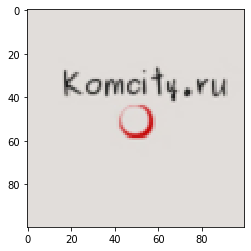

In [0]:
from matplotlib import pyplot as plt
plt.imshow(X_images[0], interpolation='nearest')
plt.show()

In [0]:
res_v = model.predict(X_images)
res_f = res_v.reshape((-1, np.prod(output_shape_model)))
res_f.shape

(500, 4608)

# Use approximate cosine similarity to find similarities
Use annoy to make queries based on approximate cosine distance. 

In [0]:
from annoy import AnnoyIndex
f_size = res_f.shape[1]
t = AnnoyIndex(f_size, 'angular')
print("Adding to tree")
for i in range(res_f.shape[0]):
  t.add_item(i, res_f[i])
print("Building...")
t.build(10) # number of trees
print("Done")

Adding to tree
Building...
Done


source_id:  336  (first is query, rest are top-k nearest)


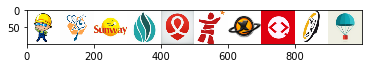

source_id:  41  (first is query, rest are top-k nearest)


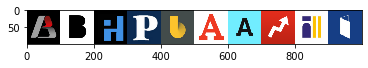

source_id:  392  (first is query, rest are top-k nearest)


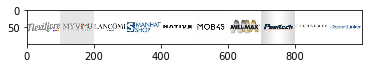

source_id:  412  (first is query, rest are top-k nearest)


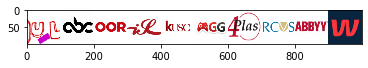

source_id:  86  (first is query, rest are top-k nearest)


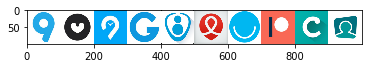

source_id:  225  (first is query, rest are top-k nearest)


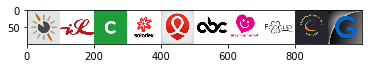

source_id:  314  (first is query, rest are top-k nearest)


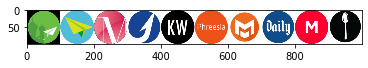

source_id:  91  (first is query, rest are top-k nearest)


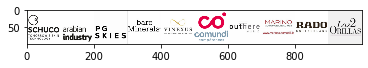

source_id:  151  (first is query, rest are top-k nearest)


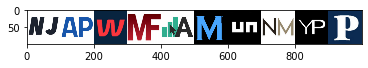

source_id:  327  (first is query, rest are top-k nearest)


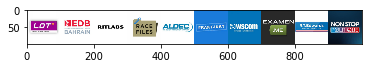

In [0]:
from matplotlib import pyplot as plt
import cv2

for i in range(10):
  source_id = np.random.choice(len(images_pp))
  print("source_id: ", source_id, " (first is query, rest are top-k nearest)")
  idx = t.get_nns_by_item(source_id, 10)
  nearest = list([images_pp[i] for i in idx])
  plt.imshow(cv2.hconcat(nearest), interpolation='nearest')
  plt.show()